<a href="https://colab.research.google.com/github/shahroz-dev/Food-Dishes-Image-Classification-with-Transfer-Learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 3: Scaling up

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the data training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

## Create Helper Function

In previous notebooks, we've created a series of helper functions to do different tasks, let's downloaded them.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-08 19:13:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-08 19:13:53 (84.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import series of helper function functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb



In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-09-08 19:13:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   228MB/s    in 6.4s    

2022-09-08 19:14:05 (241 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
# How many images /classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baby_back_ribs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hummus'.
There are 0 directories and 75 images in '101_fo

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of food classes

Here are the steps we're going to take:
* Create a ModelCheckPoint callback
* Create a data augmentaion layer to build data augmentation right into the model
* Build a headless (no top layers) functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuarcy",
                                                         save_best_only = True)

In [ ]:
# Create data augmentaion layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentaion
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescale(1/255.) # rescale of images to between 0 and 1, required for models like Resnet50V
], name = "data_augmentaion")

In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training = False) # put the base model in inference mode so weights which needs to stay frozen, stays frozen
x = layers.GlobalAveragePooling2D(name = "global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentaion (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.4755 - accuracy: 0.2486

237/237 [==============================] - 92s 323ms/step - loss: 3.4755 - accuracy: 0.2486 - val_loss: 2.7132 - val_accuracy: 0.3859
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.3485 - accuracy: 0.4611

237/237 [==============================] - 62s 258ms/step - loss: 2.3485 - accuracy: 0.4611 - val_loss: 2.2729 - val_accuracy: 0.4499
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.9926 - accuracy: 0.5298

237/237 [==============================] - 53s 221ms/step - loss: 1.9926 - accuracy: 0.5298 - val_loss: 2.0941 - val_accuracy: 0.4738
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.7619 - accuracy: 0.5698

237/237 [==============================] - 50s 208ms/step - loss: 1.7619 - accuracy: 0.5698 - val_loss: 1.9996 - val_accuracy: 0.4907
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 1.6023 - accuracy: 0.6108

237/237 [==============================] - 50s 210ms/step - loss: 1.6023 - accuracy: 0.6108 - val_loss: 1.9660 - val_accuracy: 0.4905


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 58s 73ms/step - loss: 1.7208 - accuracy: 0.5500


[1.7208118438720703, 0.5500198006629944]

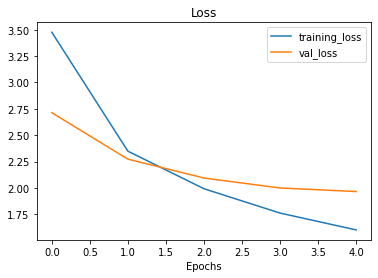

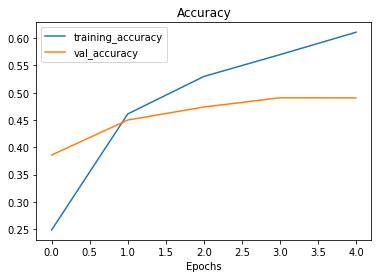

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

**Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).


## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower learning rate when doing fine-tuning)
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
              metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# What layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentaion True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model is already learned for 5 epochs (feature extraction), this is total number of epochs we were after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 56s 204ms/step - loss: 1.3611 - accuracy: 0.6446 - val_loss: 1.9237 - val_accuracy: 0.4934
Epoch 6/10
237/237 [==============================] - 42s 176ms/step - loss: 1.2373 - accuracy: 0.6739 - val_loss: 1.9041 - val_accuracy: 0.5037
Epoch 7/10
237/237 [==============================] - 41s 171ms/step - loss: 1.1650 - accuracy: 0.6910 - val_loss: 1.8674 - val_accuracy: 0.5154
Epoch 8/10
237/237 [==============================] - 39s 165ms/step - loss: 1.0933 - accuracy: 0.7113 - val_loss: 1.8919 - val_accuracy: 0.5074
Epoch 9/10
237/237 [==============================] - 42s 174ms/step - loss: 1.0247 - accuracy: 0.7278 - val_loss: 1.9004 - val_accuracy: 0.5082
Epoch 10/10
237/237 [==============================] - 39s 162ms/step - loss: 0.9704 - accuracy: 0.7387 - val_loss: 1.8345 - val_accuracy: 0.5283


In [ ]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 57s 72ms/step - loss: 1.6223 - accuracy: 0.5749


[1.6222679615020752, 0.5748910903930664]

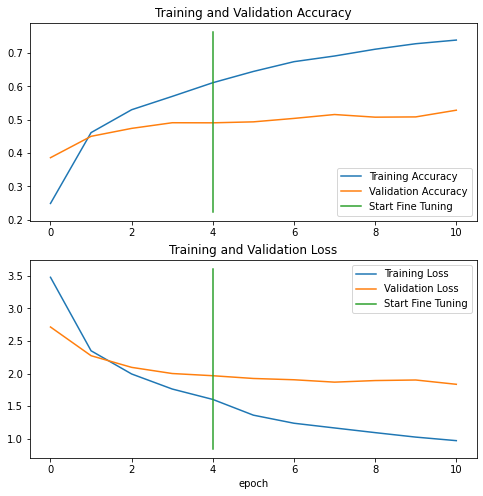

In [ ]:
# Compare historys
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune, initial_epochs = 5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere

In [ ]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/Tensorflow saved models/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Load and Evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Tensorflow saved models/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 60s 74ms/step - loss: 1.6223 - accuracy: 0.5749


[1.6222679615020752, 0.5748910903930664]

In [ ]:
# The results from our loaded model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.6222679615020752, 0.5748910903930664]